## Charmonia Primordial Suppression in pPb Collision

## Load & Preprocess Datafiles

### Imports & Data Loading

In [22]:
# --- imports & search path ---
import sys
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

project = Path.cwd()
sys.path.insert(0, str(project / "combined_code"))

from primordial_module import (
    ReaderConfig,
    build_ensemble,
    make_bins_from_width,
    Style,
    Y_WINDOW_FORWARD,
    Y_WINDOW_BACKWARD,
    Y_WINDOW_CENTRAL,
)

# ---------- I/O + switches ----------
outdir = project / "primordial_output_simple"
outdir.mkdir(exist_ok=True, parents=True)

SAVE_PDF = True
SAVE_CSV = True
DPI = 150
ALPHA_BAND = 0.22

# ---------- choose energy (string, like CNM notebook) ----------
ENERGY = "8.16"   # "8.16" or "5.02"
SQRTS_GeV = 8160.0 if ENERGY == "8.16" else 5020.0
MODELS = ("Pert", "NPWLC")

# ---------- input paths: one formation-time set ("new") ----------
PATHS = {
    "8.16": {
        "Pert":  project / "input/primordial/pPb8TeV/output_new_form/output_8pPb_Tf170_Pert",
        "NPWLC": project / "input/primordial/pPb8TeV/output_new_form/output_8pPb_Tf170_NPWLC",
    },
    "5.02": {
        "Pert":  project / "input/primordial/pPb5TeV/output_new_form/output_5pPb_Tf170_Pert",
        "NPWLC": project / "input/primordial/pPb5TeV/output_new_form/output_5pPb_Tf170_NPWLC",
    },
}

glauber = {
    "8.16": project / "input/glauber_data/8TeV",
    "5.02": project / "input/glauber_data/5TeV",
}

# --- Formation-times (in fm) for charmonium states (new scheme only) ---
TAUFORM = {
    "jpsi_1S":  (0.31, 0.62),
    "chicJ_1P": (1.20, 2.40),
    "psi_2S":   (4.50, 9.00),
}

STATE_SHORT  = {"jpsi_1S": "1S", "chicJ_1P": "1P", "psi_2S": "2S"}
STATE_LABELS = {
    "jpsi_1S":  r"$J/\psi(1S)$",
    "chicJ_1P": r"$\chi_c(1P)$",
    "psi_2S":   r"$\psi(2S)$",
}
STATES = ("jpsi_1S", "chicJ_1P", "psi_2S")

# Colors & linestyles: *model-coded*, like you asked
MODEL_COLORS = {"Pert": "tab:blue", "NPWLC": "tab:red"}
MODEL_LS     = {"Pert": "-",        "NPWLC": "--"}

# ---------- style ----------
Style.apply()
mpl.rcParams.update({
    "font.size": 11,
    "xtick.major.size": 6, "ytick.major.size": 6,
    "xtick.minor.size": 3, "ytick.minor.size": 3,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "axes.unicode_minus": False,
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.framealpha": 0.9,
    "legend.borderpad": 0.6,
    "legend.handlelength": 2.0,
})

# ---------- physics binning ----------
Y_BINS    = make_bins_from_width(-5.0, 5.0, 0.5)
PT_BINS   = make_bins_from_width(0.0, 15.0, 2.5)
PT_WINDOW = (0.0, 15.0)

Y_WINS = {
    "forward":  Y_WINDOW_FORWARD,   # (y_min, y_max, name)
    "backward": Y_WINDOW_BACKWARD,
    "central":  Y_WINDOW_CENTRAL,
}

# same centrality bins as CNM notebook (can change externally)
CENT_CLASSES = [(0,20), (20,40), (40,60), (60,80), (80,100)]

cfg = ReaderConfig(debug=False)

In [23]:
@dataclass
class PrimordialCombo:
    energy: str
    model: str
    ens: object
    runs: dict

def _try_build_single(energy: str, model: str) -> PrimordialCombo | None:
    base = PATHS[energy][model]
    try:
        ens, runs = build_ensemble(
            str(base),
            str(glauber[energy]),
            tags=("tau1", "tau2"),    # two tau_form values → band
            cfg=cfg,
            sqrts_NN=float(energy),   # 8.16 or 5.02
        )
    except FileNotFoundError as e:
        print(f"[WARN] Missing primordial input for {energy} TeV, {model}: {e}")
        return None
    return PrimordialCombo(energy=energy, model=model, ens=ens, runs=runs)

def load_primordial_combos(energy: str):
    combos = []
    for m in MODELS:
        c = _try_build_single(energy, m)
        if c is not None:
            combos.append(c)
    assert combos, f"No primordial combos found for energy={energy}"
    return combos

present = load_primordial_combos(ENERGY)
# present

### Utilities & Helpers

In [24]:
def _maps_from_runs(runs_dict):
    # centrality mapping object (b → Ncoll, centrality %, etc.)
    return next(iter(runs_dict.values())).centrality

def _centrality_percent(maps, bvals):
    """
    Map impact parameters b -> centrality [%] using the Glauber mapping.

    If maps.b_to_c gives 0–1 or 0–200 etc., we rescale to ~0–100.
    If the mapping is weird / too narrow, fall back to equal-spacing in [0,100].
    """
    bvals = np.asarray(bvals, float)
    c = maps.b_to_c(bvals).astype(float)

    if np.isfinite(c).any():
        cmax = float(np.nanmax(c))
        if cmax <= 1.5:          # 0–1 → 0–100
            c *= 100.0
        elif cmax > 150.0:       # 0–200 → 0–100
            c /= (cmax / 100.0)

    good = np.isfinite(c)
    span = (np.nanmax(c[good]) - np.nanmin(c[good])) if good.any() else 0.0

    # If mapping is pathological, build an equal-spaced 0–100 centrality scale.
    if (not good.all()) or (span < 5.0):
        bu = np.unique(bvals)
        n  = len(bu)
        centers = (np.arange(n) + 0.5) * (100.0 / max(1, n))
        order   = np.argsort(bu)
        c = np.interp(bvals, bu[order], centers[order])

    return c

def _edges_from_centers(centers, lo=None, hi=None):
    centers = np.sort(np.unique(np.asarray(centers, float)))
    if centers.size == 0:
        return np.array([0.0, 1.0])
    if centers.size == 1:
        left, right = centers[0]-0.5, centers[0]+0.5
        if lo is not None: left = lo
        if hi is not None: right = hi
        return np.array([left, right], float)
    mids = 0.5 * (centers[1:] + centers[:-1])
    edges = np.r_[centers[0] - (mids[0]-centers[0]), mids, centers[-1] + (centers[-1]-mids[-1])]
    if lo is not None: edges[0]  = lo
    if hi is not None: edges[-1] = hi
    return edges

def _corner(ax, text, loc="tr"):
    pos = {"tl":(0.02,0.98),"tr":(0.98,0.98),"bl":(0.02,0.02),"br":(0.98,0.02)}[loc]
    ha = "left" if "l" in loc else "right"
    va = "top"  if "t" in loc else "bottom"
    ax.text(
        pos[0], pos[1], text,
        transform=ax.transAxes,
        ha=ha, va=va,
        fontsize=10,
        bbox=dict(facecolor="white", alpha=0.85, edgecolor="none"),
    )


In [ ]:
def _aggregate_class(df_center_b, df_band_b, maps, cent_lo, cent_hi, states, xname, weight="nbin"):
    """
    Aggregate R_pA(x; b) over all b in a centrality class [cent_lo, cent_hi),
    using N_coll weights (default).
    xname = 'y' or 'pt'.
    """
    bs = np.sort(df_center_b["b"].unique())
    cents = _centrality_percent(maps, bs)

    # select bs in the desired centrality slice
    sel_b = bs[(cents >= cent_lo) & (cents < cent_hi)]
    if sel_b.size == 0:
        return None, None

    dc = df_center_b[df_center_b["b"].isin(sel_b)].copy()
    db = df_band_b[df_band_b["b"].isin(sel_b)].copy() if df_band_b is not None else None

    # weights: N_bin (i.e. N_coll) or flat
    if weight == "nbin":
        wvals = maps.b_to_nbin(sel_b)
        wvals = np.where((wvals > 0) & np.isfinite(wvals), wvals, 1.0)
    else:
        wvals = np.ones_like(sel_b, float)
    wvals = wvals / wvals.sum()

    wmap = dict(zip(sel_b, wvals))

    # center values (weighted mean)
    rows = []
    for xv, chunk in dc.groupby(xname, sort=True):
        ws = np.array([wmap[b] for b in chunk["b"]], float)
        row = {xname: float(xv)}
        for s in states:
            vals = chunk[s].to_numpy(float)
            row[s] = float(np.sum(ws * vals))
        rows.append(row)
    dfc = pd.DataFrame(rows).sort_values(xname).reset_index(drop=True)

    # band: just min / max across all bs in this class for each x
    dfb = None
    if df_band_b is not None:
        rowsb = []
        for xv, ch in db.groupby(xname, sort=True):
            rb = {xname: float(xv)}
            for s in states:
                lo = ch.get(f"{s}_lo", pd.Series(dtype=float))
                hi = ch.get(f"{s}_hi", pd.Series(dtype=float))
                if not lo.empty and not hi.empty:
                    rb[f"{s}_lo"] = float(np.nanmin(lo.to_numpy(float)))
                    rb[f"{s}_hi"] = float(np.nanmax(hi.to_numpy(float)))
            rowsb.append(rb)
        dfb = pd.DataFrame(rowsb).sort_values(xname).reset_index(drop=True)

    return dfc, dfb

def step_from_centers(x_cent, vals):
    x_cent = np.asarray(x_cent, float)
    vals   = np.asarray(vals, float)
    assert x_cent.size == vals.size

    if x_cent.size > 1:
        dx = np.diff(x_cent)
        dx0 = dx[0]
        if not np.allclose(dx, dx0):
            raise ValueError("x_cent not uniformly spaced")
    else:
        dx0 = 1.0

    x_edges = np.concatenate(([x_cent[0] - 0.5 * dx0], x_cent + 0.5 * dx0))
    y_step  = np.concatenate([vals, vals[-1:]])
    return x_edges, y_step

def _iter_ywins(y_wins):
    """
    Yield (name, y0, y1) for entries in Y_WINS.
    Works whether the value is (y0, y1) or (y0, y1, name).
    """
    for key, win in y_wins.items():
        win = tuple(win)
        if len(win) == 3:
            y0, y1, yname = win
        elif len(win) == 2:
            y0, y1 = win
            yname = key
        else:
            raise ValueError(f"Bad y-window spec for {key}: {win}")
        yield yname, y0, y1

## $R_{pA}$ vs Rapidity

In [26]:
# Everything is stored here for later reuse / CNM × primordial combination
prim_y = {}   # prim_y[model][cent_tag][state] = (Rc, Rlo, Rhi, y_cent)

def primordial_vs_y_all(
    combos,
    states=STATES,
    cent_classes=CENT_CLASSES,
    pt_window=PT_WINDOW,
    y_bins=Y_BINS,
):
    """
    For each model and each centrality (including MB), compute
    R_pA(y) in the given pT window.
    """
    results = {c.model: {} for c in combos}

    for combo in combos:
        maps = _maps_from_runs(combo.runs)

        # raw per-b data
        dfC_b, dfB_b = combo.ens.central_and_band_vs_y_per_b(
            pt_window=pt_window,
            y_bins=y_bins,
            with_feeddown=True,
            use_nbin=True,
            flip_y=True,
        )

        # add a min-bias "0-100%" class on top of explicit classes
        cent_slices = list(cent_classes) + [(0, 100)]
        for (lo, hi) in cent_slices:
            tag = f"{int(lo)}–{int(hi)}%" if (lo, hi) != (0, 100) else "0–100% (MB)"

            dfc, dfb = _aggregate_class(dfC_b, dfB_b, maps, lo, hi, states, "y")
            if dfc is None:
                continue

            y_cent = dfc["y"].to_numpy(float)
            entry = {}
            for s in states:
                Rc  = dfc[s].to_numpy(float)
                if dfb is not None and f"{s}_lo" in dfb:
                    Rlo = dfb[f"{s}_lo"].to_numpy(float)
                    Rhi = dfb[f"{s}_hi"].to_numpy(float)
                else:
                    Rlo = Rc
                    Rhi = Rc
                entry[s] = (Rc, Rlo, Rhi, y_cent)

            results[combo.model][tag] = entry

    return results

def _sorted_cent_tags(prim_y_for_models):
    """
    Get a nice ordering of centrality tags, with MB last:
    ['0–10%', '10–20%', ..., '80–100%', '0–100% (MB)'].
    """
    all_tags = set()
    for m in prim_y_for_models:
        all_tags.update(prim_y_for_models[m].keys())

    mb_tags = [t for t in all_tags if "MB" in t]
    non_mb  = [t for t in all_tags if "MB" not in t]

    def _cent_key(tag):
        lo, hi = tag.split("–")
        lo = float(lo)
        return lo

    non_mb_sorted = sorted(non_mb, key=_cent_key)
    return non_mb_sorted + mb_tags


prim_y = primordial_vs_y_all(present)

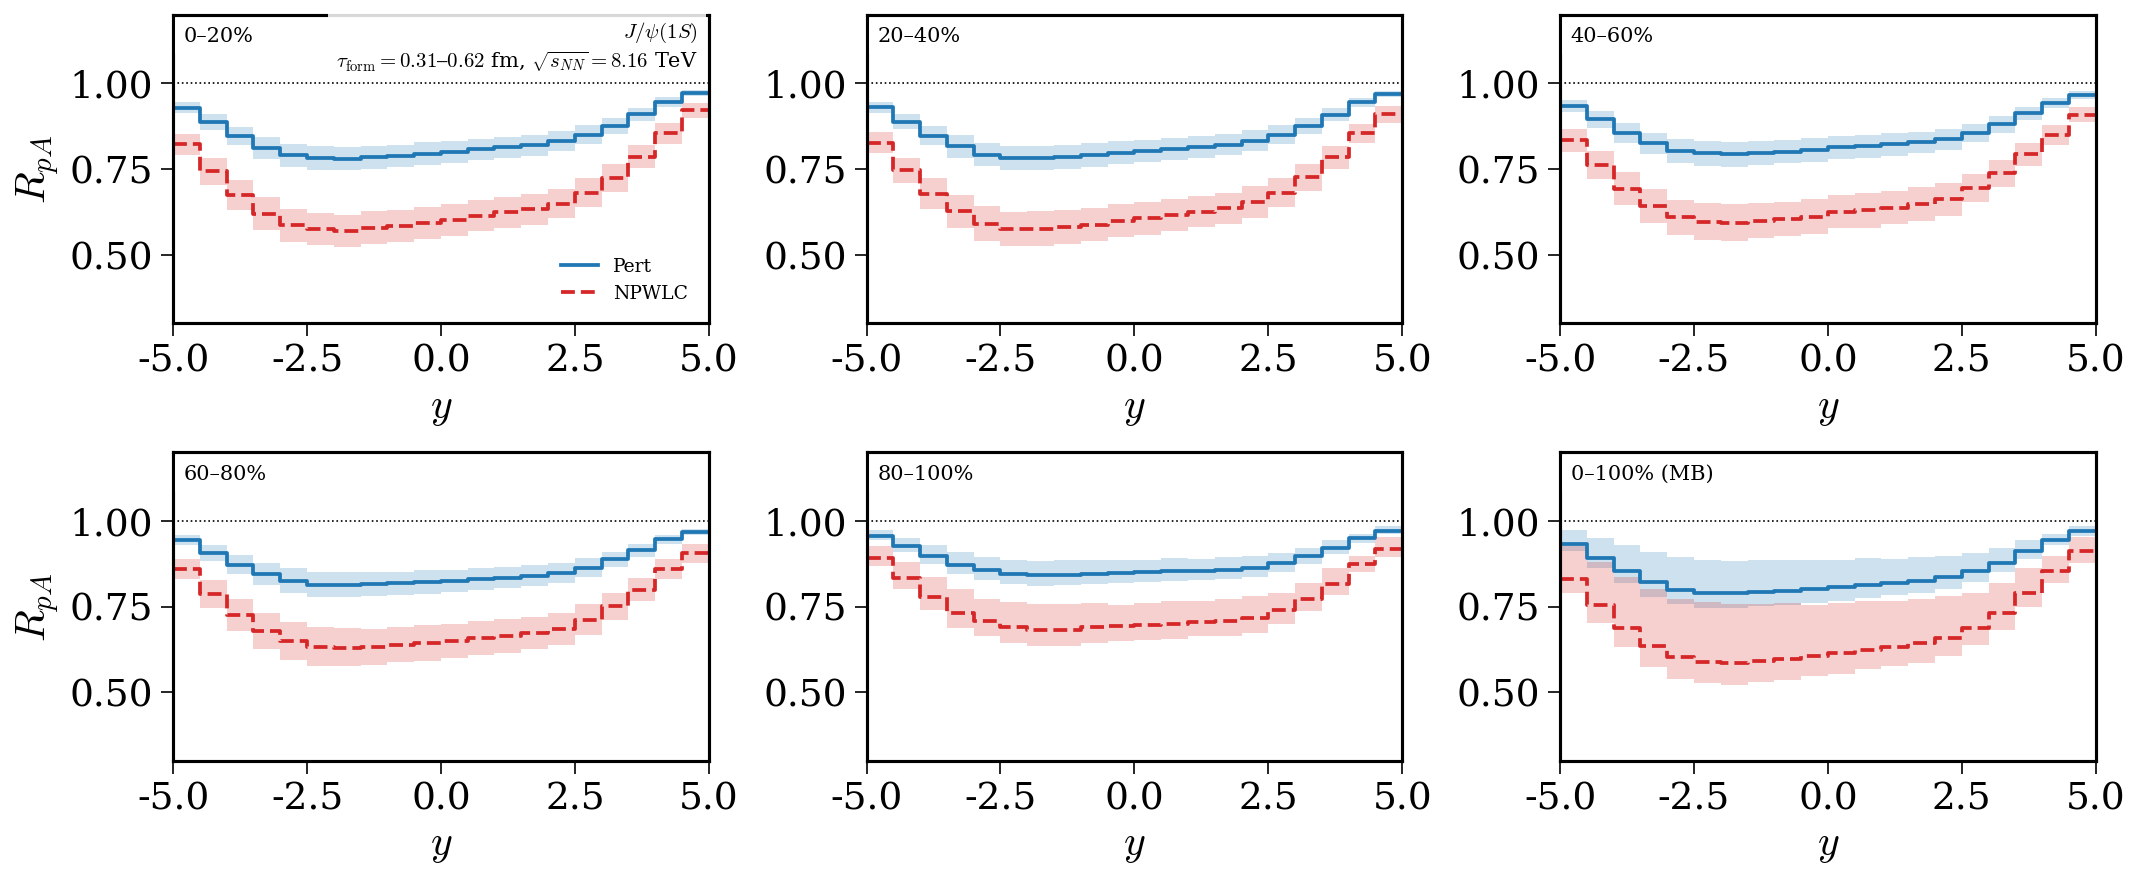

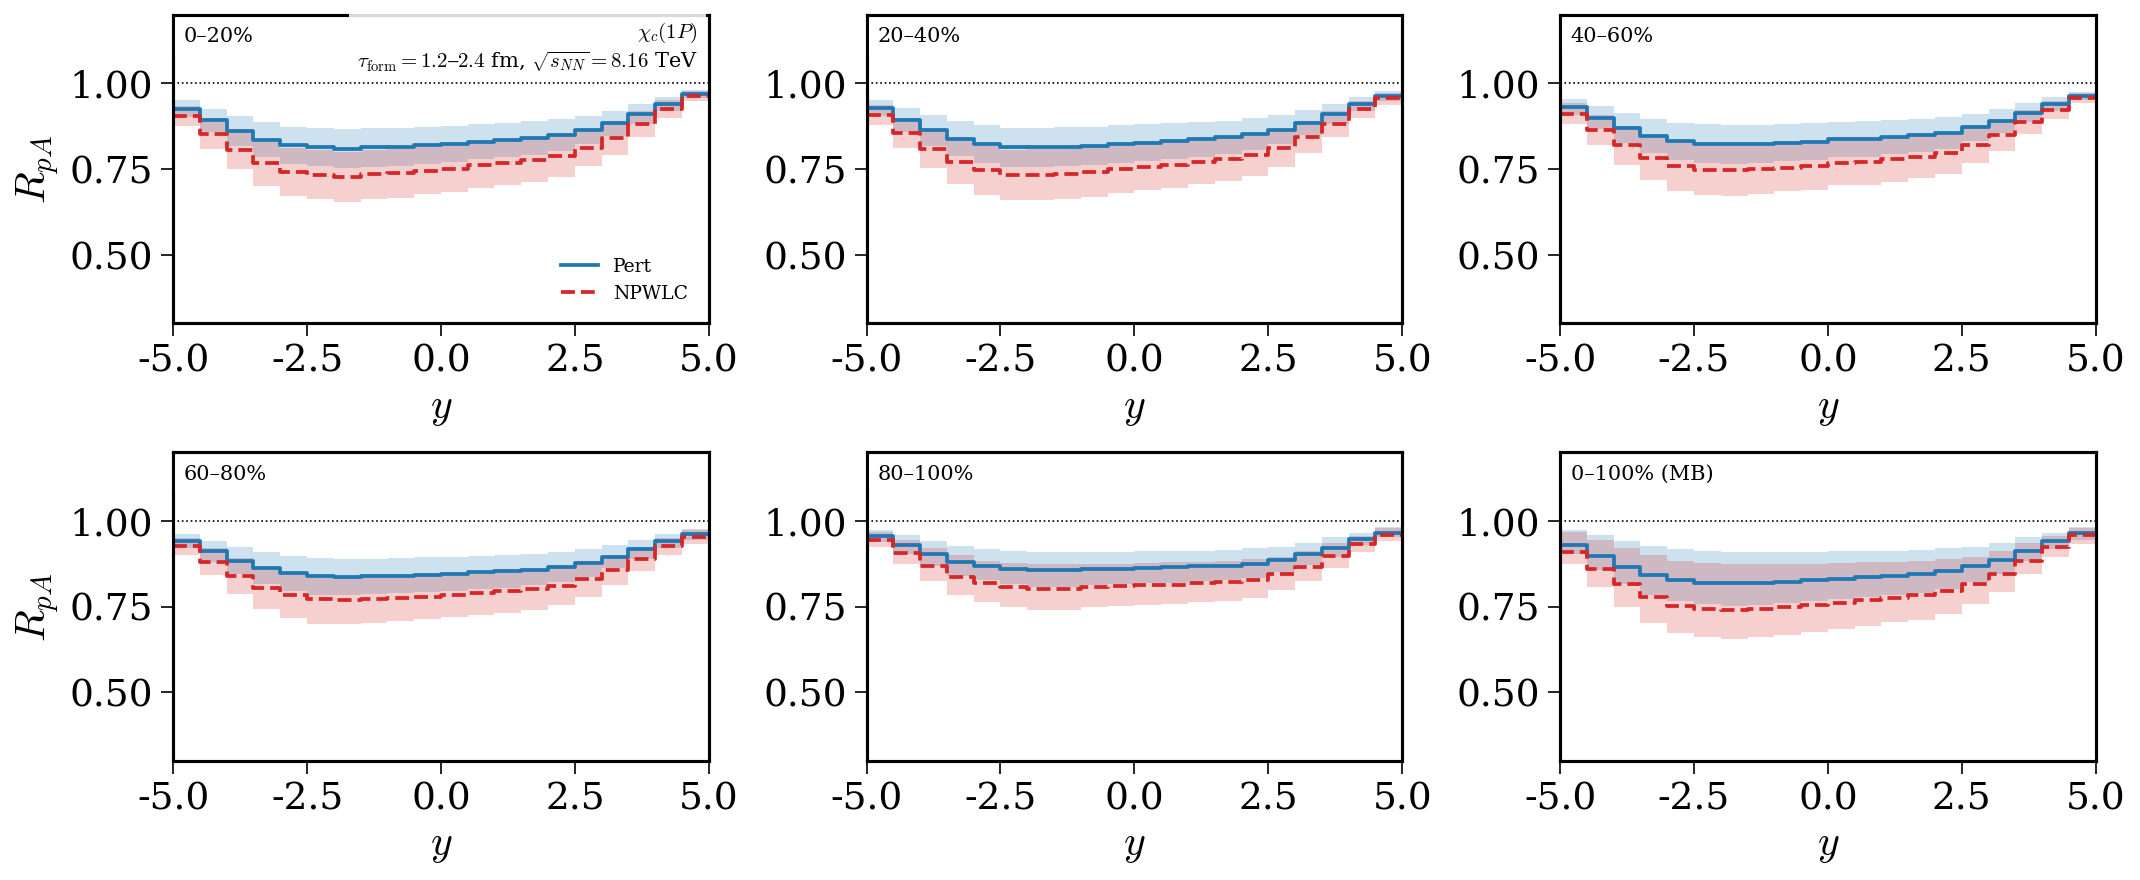

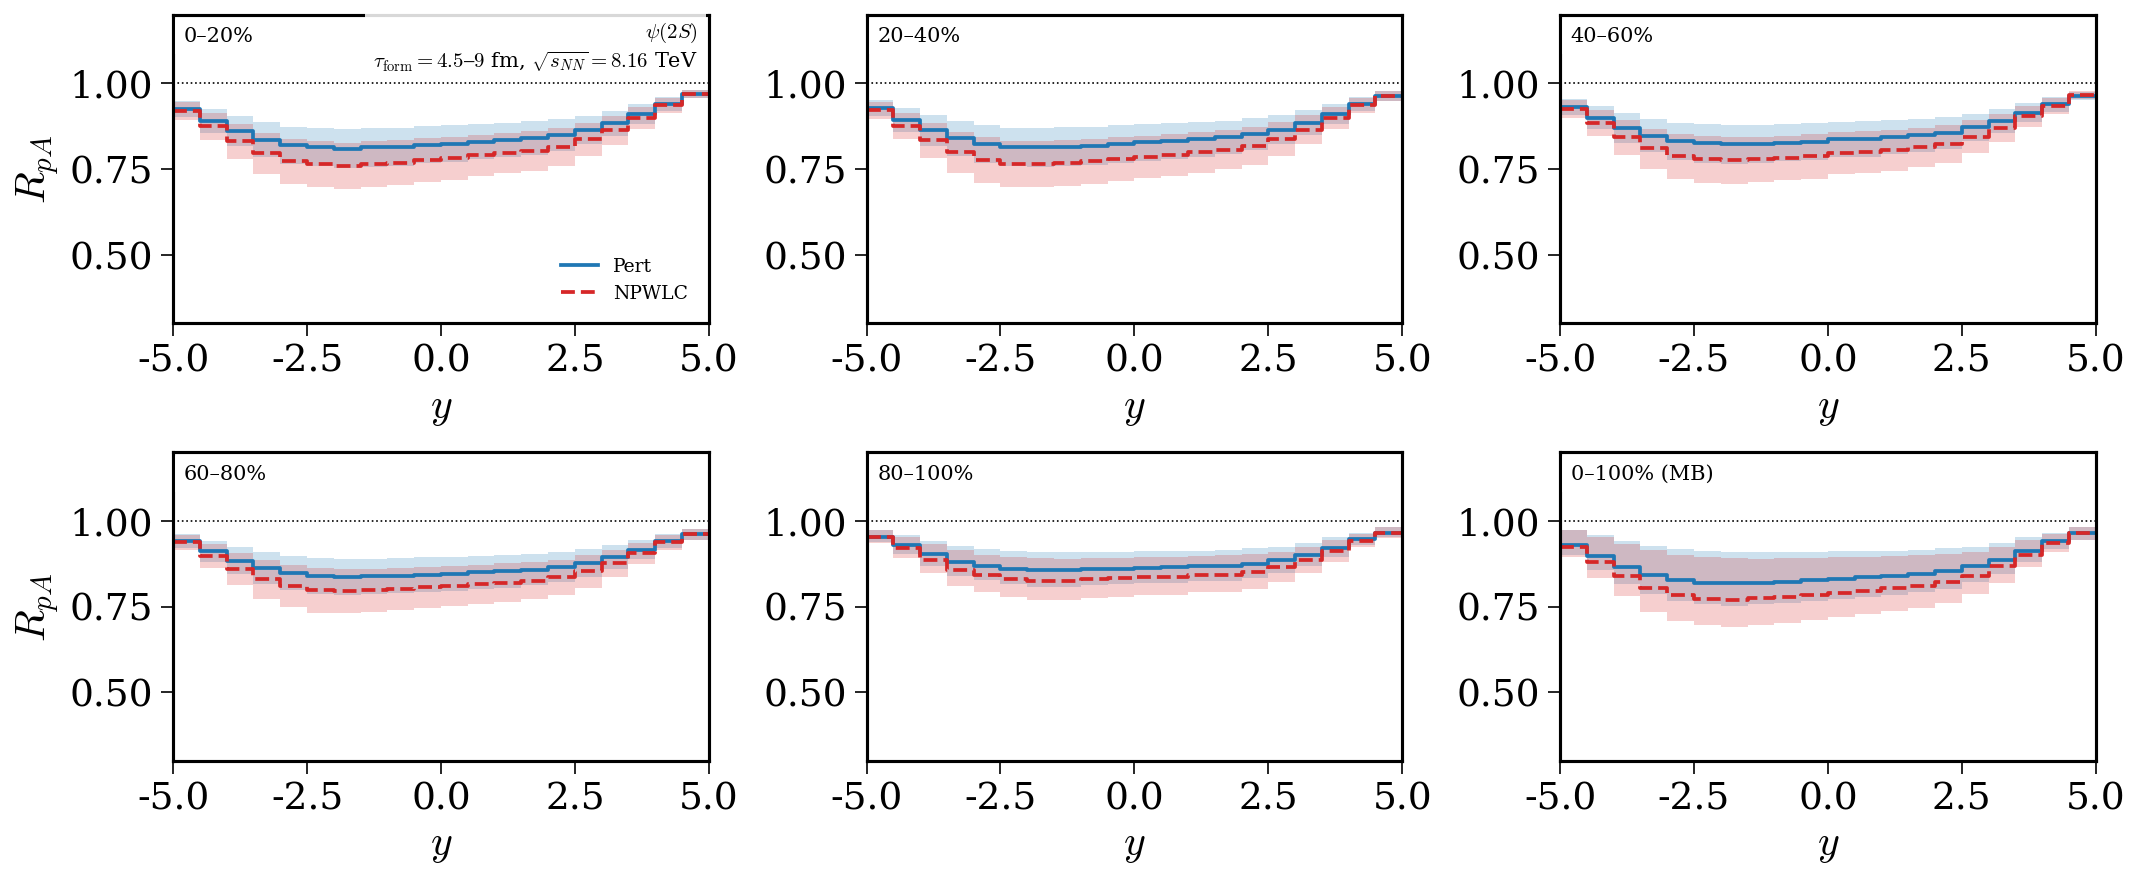

In [27]:
# ------------- R_pA vs y: one figure per state, centrality panels -------------
PLOT_STATES = STATES  # or subset like ("jpsi_1S",)

for state in PLOT_STATES:
    cent_tags = _sorted_cent_tags(prim_y)
    n_cent = len(cent_tags)
    n_cols = 3
    n_rows = int(np.ceil(n_cent / n_cols))

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4.8 * n_cols, 3.0 * n_rows),
        dpi=DPI, sharex=False, sharey=False
    )
    axes = np.atleast_1d(axes).ravel()

    for ip, cent_tag in enumerate(cent_tags):
        ax = axes[ip]

        for model in MODELS:
            if cent_tag not in prim_y[model]:
                continue
            if state not in prim_y[model][cent_tag]:
                continue

            Rc, Rlo, Rhi, y_cent = prim_y[model][cent_tag][state]
            x_edges, y_c  = step_from_centers(y_cent, Rc)
            _,       y_lo = step_from_centers(y_cent, Rlo)
            _,       y_hi = step_from_centers(y_cent, Rhi)

            col = MODEL_COLORS[model]
            ls  = MODEL_LS[model]
            lab = model if ip == 0 else None   # legend: Pert / NPWLC only

            ax.step(x_edges, y_c, where="post", color=col, ls=ls, lw=1.8, label=lab)
            ax.fill_between(
                x_edges, y_lo, y_hi,
                step="post",
                color=col, alpha=ALPHA_BAND, linewidth=0.0
            )

        ax.axhline(1.0, color="k", ls=":", lw=0.8)
        ax.set_xlim(-5, 5)
        ax.set_ylim(0.3, 1.2)
        ax.set_xlabel(r"$y$")
        if ip % n_cols == 0:
            ax.set_ylabel(r"$R_{pA}$")
        ax.grid(False)

        # small centrality label in the panel instead of a title
        ax.text(
            0.02, 0.96, cent_tag,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none")
        )

    # hide unused axes
    for k in range(n_cent, len(axes)):
        axes[k].set_visible(False)

    # legend: models only (Pert / NPWLC)
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(handles, labels, loc="lower right", fontsize=9, frameon=False)

    # put state + τ_form + √s note inside first panel (no pT note)
    tau_lo, tau_hi = TAUFORM[state]
    note = (
        f"{STATE_LABELS[state]}\n"
        rf"$\tau_{{\rm form}}={tau_lo:.2g}\text{{–}}{tau_hi:.2g}$ fm, "
        rf"$\sqrt{{s_{{NN}}}}={float(ENERGY):.2f}$ TeV"
    )
    _corner(axes[0], note, loc="tr")

    fig.tight_layout()

    if SAVE_PDF:
        fig.savefig(
            outdir / f"primordial_RpA_vs_y_{state}_{ENERGY.replace('.','p')}TeV.pdf",
            bbox_inches="tight"
        )

    # CSV export per state (good for CNM×primordial)
    if SAVE_CSV:
        rows = []
        for model in MODELS:
            for cent_tag in prim_y[model]:
                if state not in prim_y[model][cent_tag]:
                    continue
                Rc, Rlo, Rhi, y_cent = prim_y[model][cent_tag][state]
                for yv, rc, rlo, rhi in zip(y_cent, Rc, Rlo, Rhi):
                    rows.append({
                        "energy": ENERGY,
                        "model":  model,
                        "centrality": cent_tag,
                        "state": state,
                        "y": yv,
                        "R": rc,
                        "R_lo": rlo,
                        "R_hi": rhi,
                    })
        if rows:
            df_out = pd.DataFrame(rows)
            df_out.to_csv(
                outdir / f"primordial_RpA_vs_y_{state}_{ENERGY.replace('.','p')}TeV.csv",
                index=False,
            )

## $R_{pA}$ vs Transverse Momentum

In [28]:
prim_pt = {}  # prim_pt[yname][model][cent_tag][state] = (Rc,Rlo,Rhi, pT_cent)

def primordial_vs_pT_all(
    combos,
    states=STATES,
    cent_classes=CENT_CLASSES,
    y_wins=Y_WINS,
    pt_bins=PT_BINS,
):
    out = {}
    for yname, y0, y1 in _iter_ywins(y_wins):
        out[yname] = {c.model: {} for c in combos}
        for combo in combos:
            maps = _maps_from_runs(combo.runs)
            dfC_b, dfB_b = combo.ens.central_and_band_vs_pt_per_b(
                y_window=(y0, y1, yname),
                pt_bins=pt_bins,
                with_feeddown=True,
                use_nbin=True,
            )
            cent_slices = list(cent_classes) + [(0, 100)]
            for (lo, hi) in cent_slices:
                tag = f"{int(lo)}–{int(hi)}%" if (lo, hi) != (0, 100) else "0–100% (MB)"
                dfc, dfb = _aggregate_class(dfC_b, dfB_b, maps, lo, hi, states, "pt")
                if dfc is None:
                    continue
                pT_cent = dfc["pt"].to_numpy(float)
                entry = {}
                for s in states:
                    Rc  = dfc[s].to_numpy(float)
                    if dfb is not None and f"{s}_lo" in dfb:
                        Rlo = dfb[f"{s}_lo"].to_numpy(float)
                        Rhi = dfb[f"{s}_hi"].to_numpy(float)
                    else:
                        Rlo = Rc
                        Rhi = Rc
                    entry[s] = (Rc, Rlo, Rhi, pT_cent)
                out[yname][combo.model][tag] = entry
    return out

prim_pt = primordial_vs_pT_all(present)

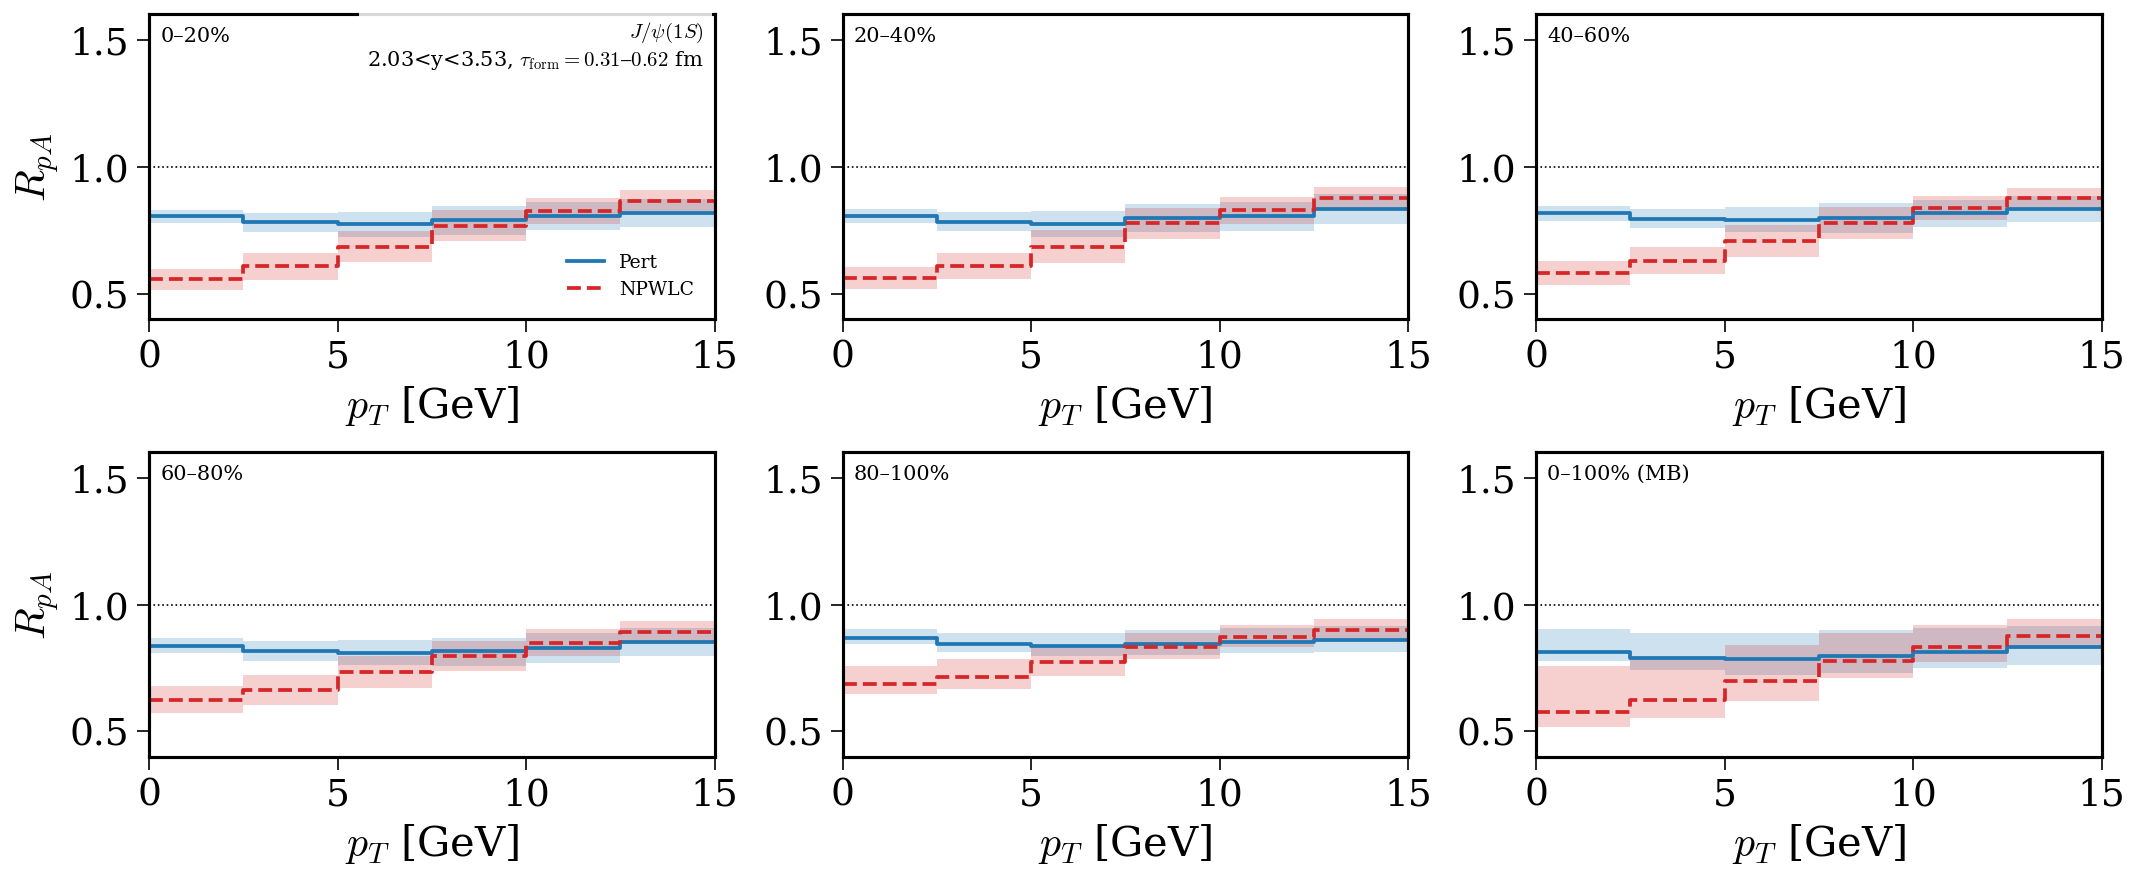

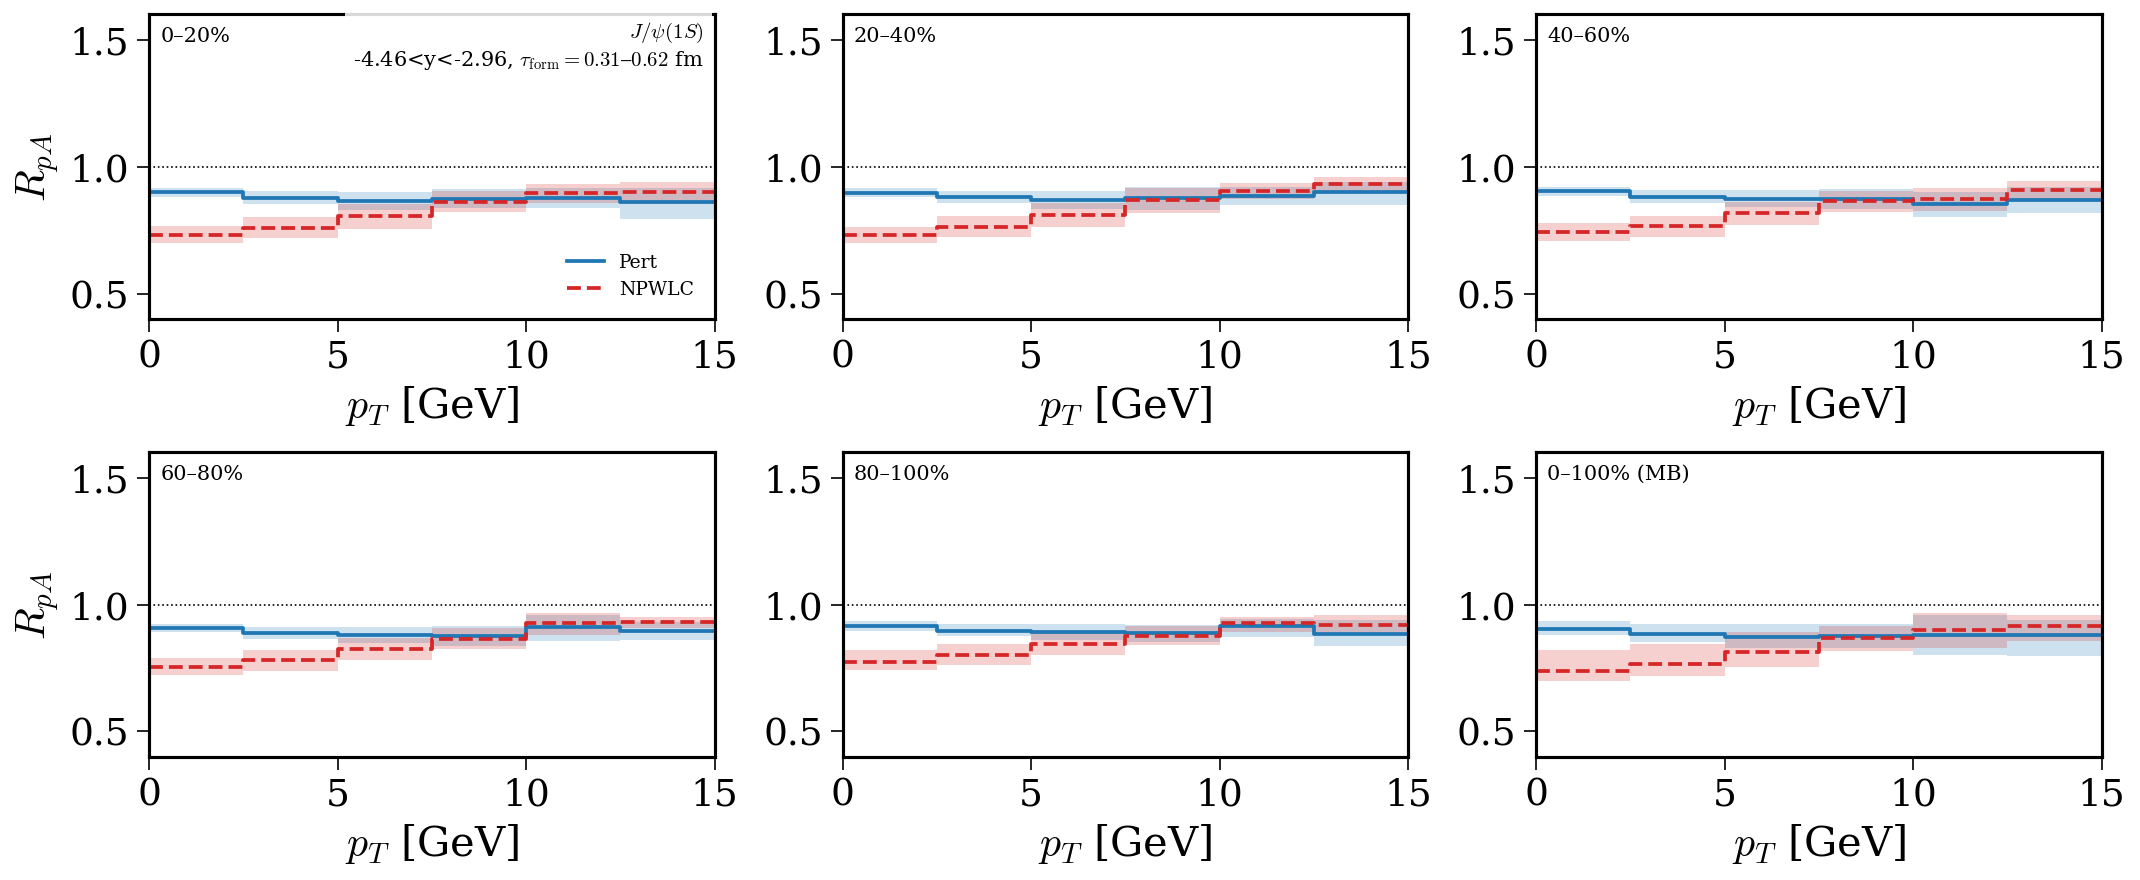

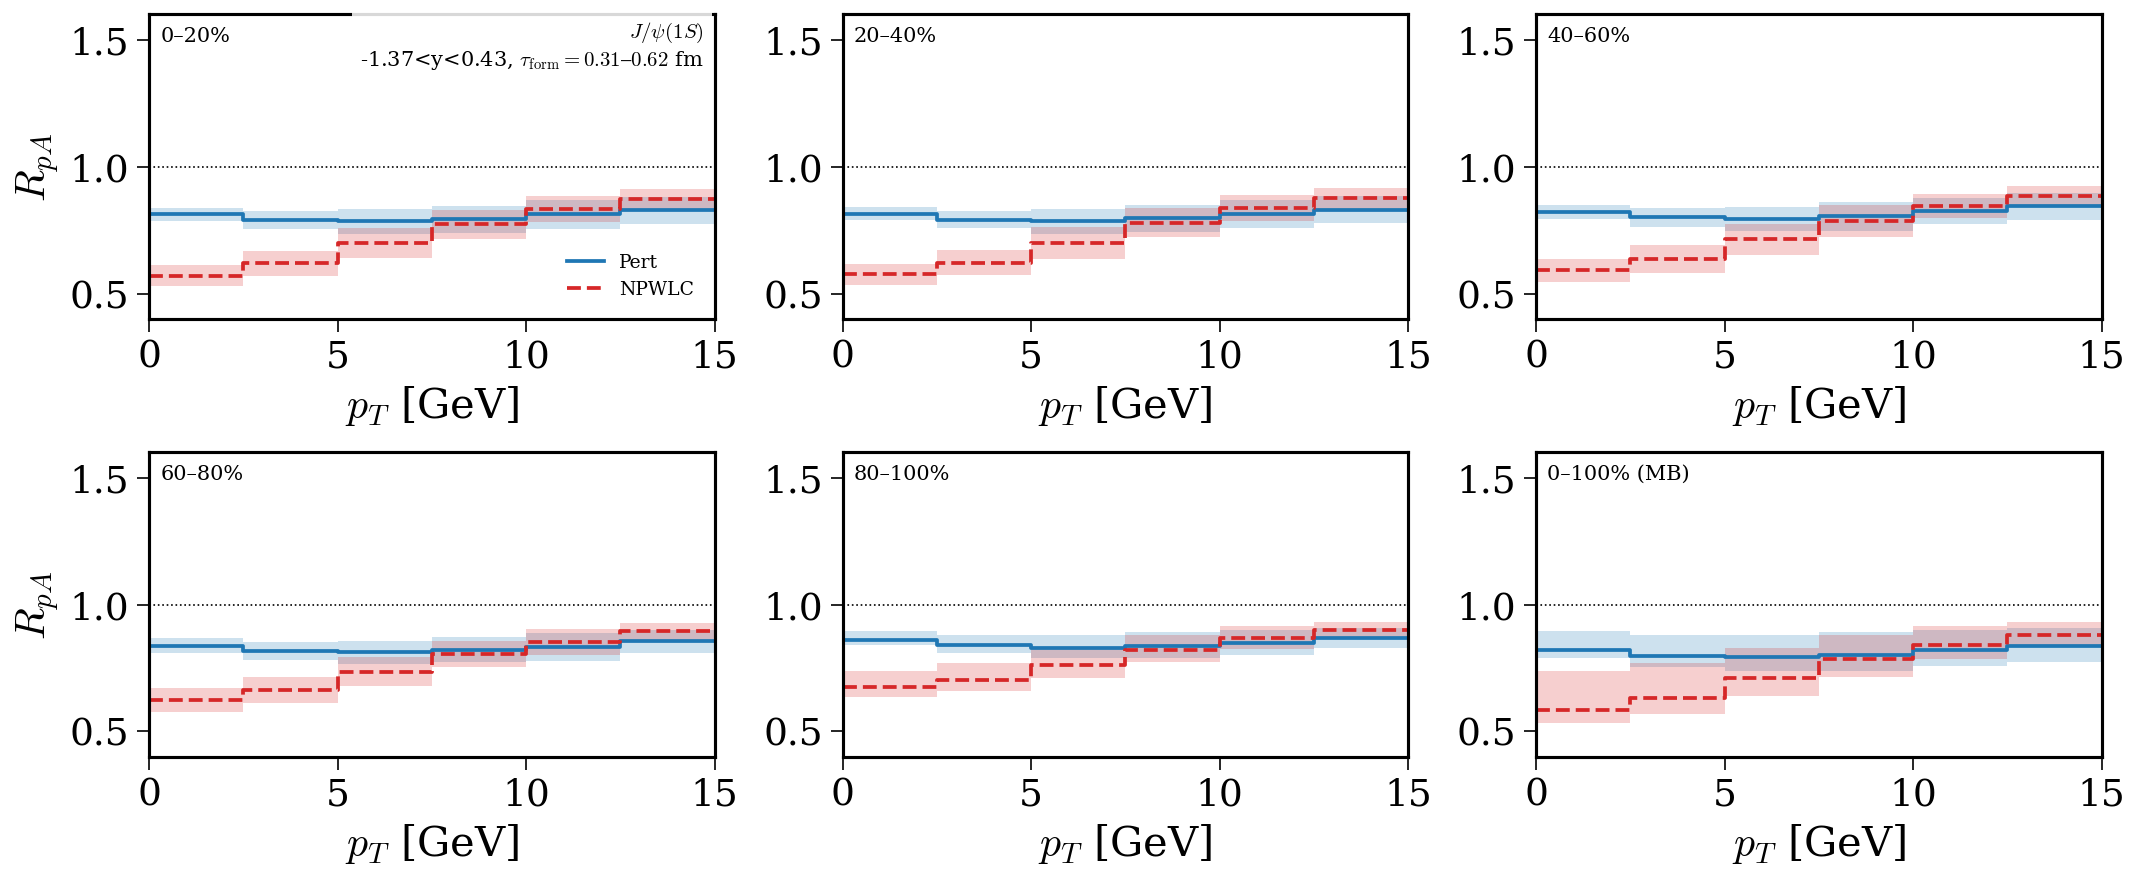

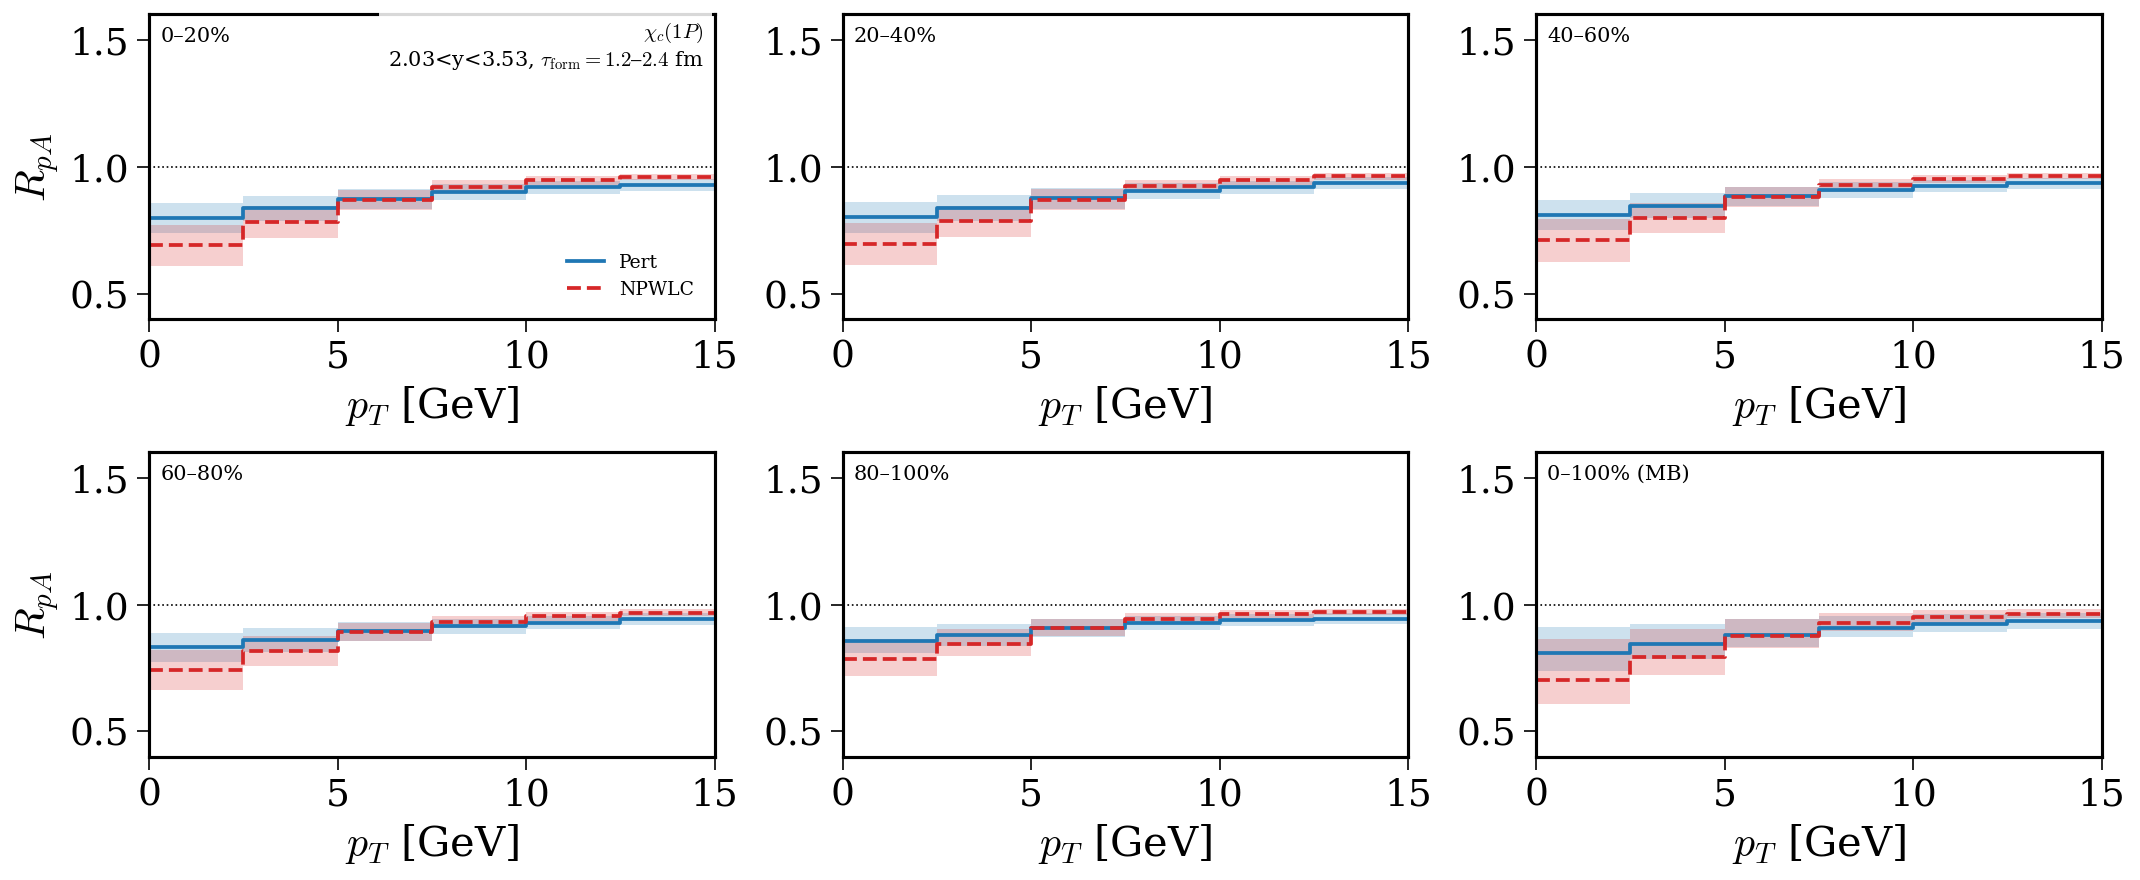

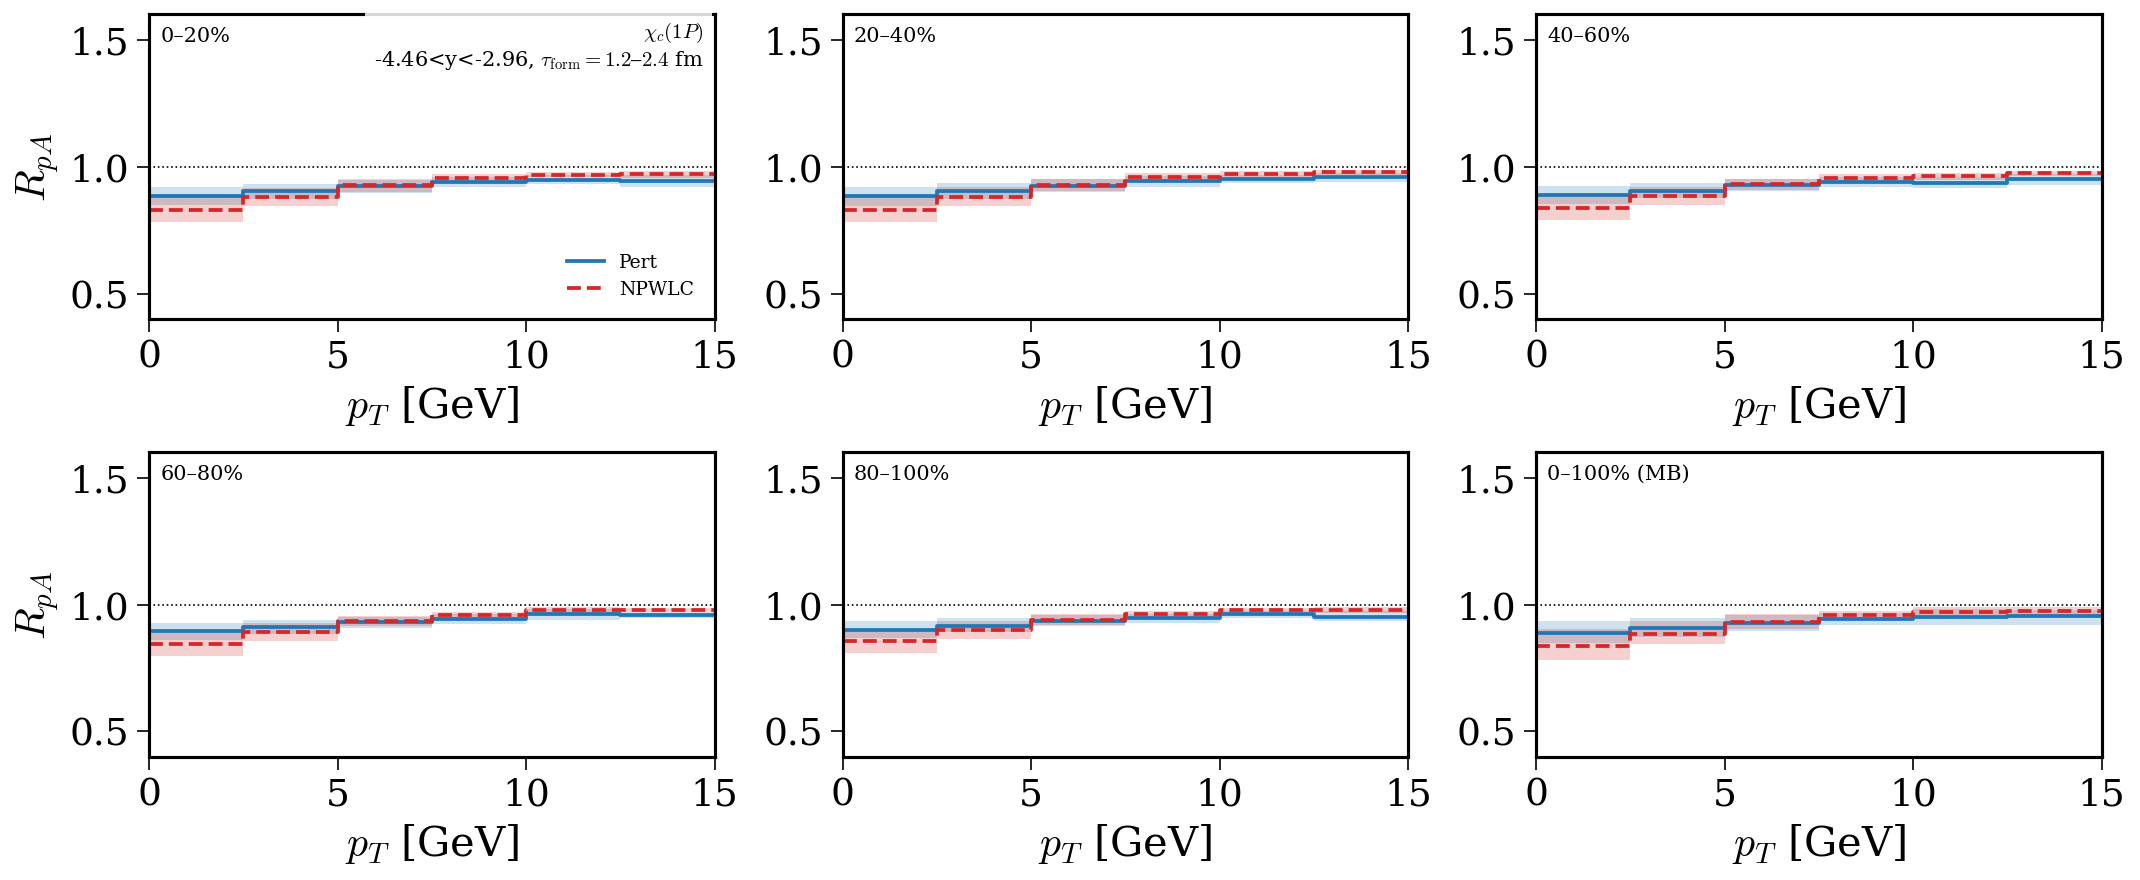

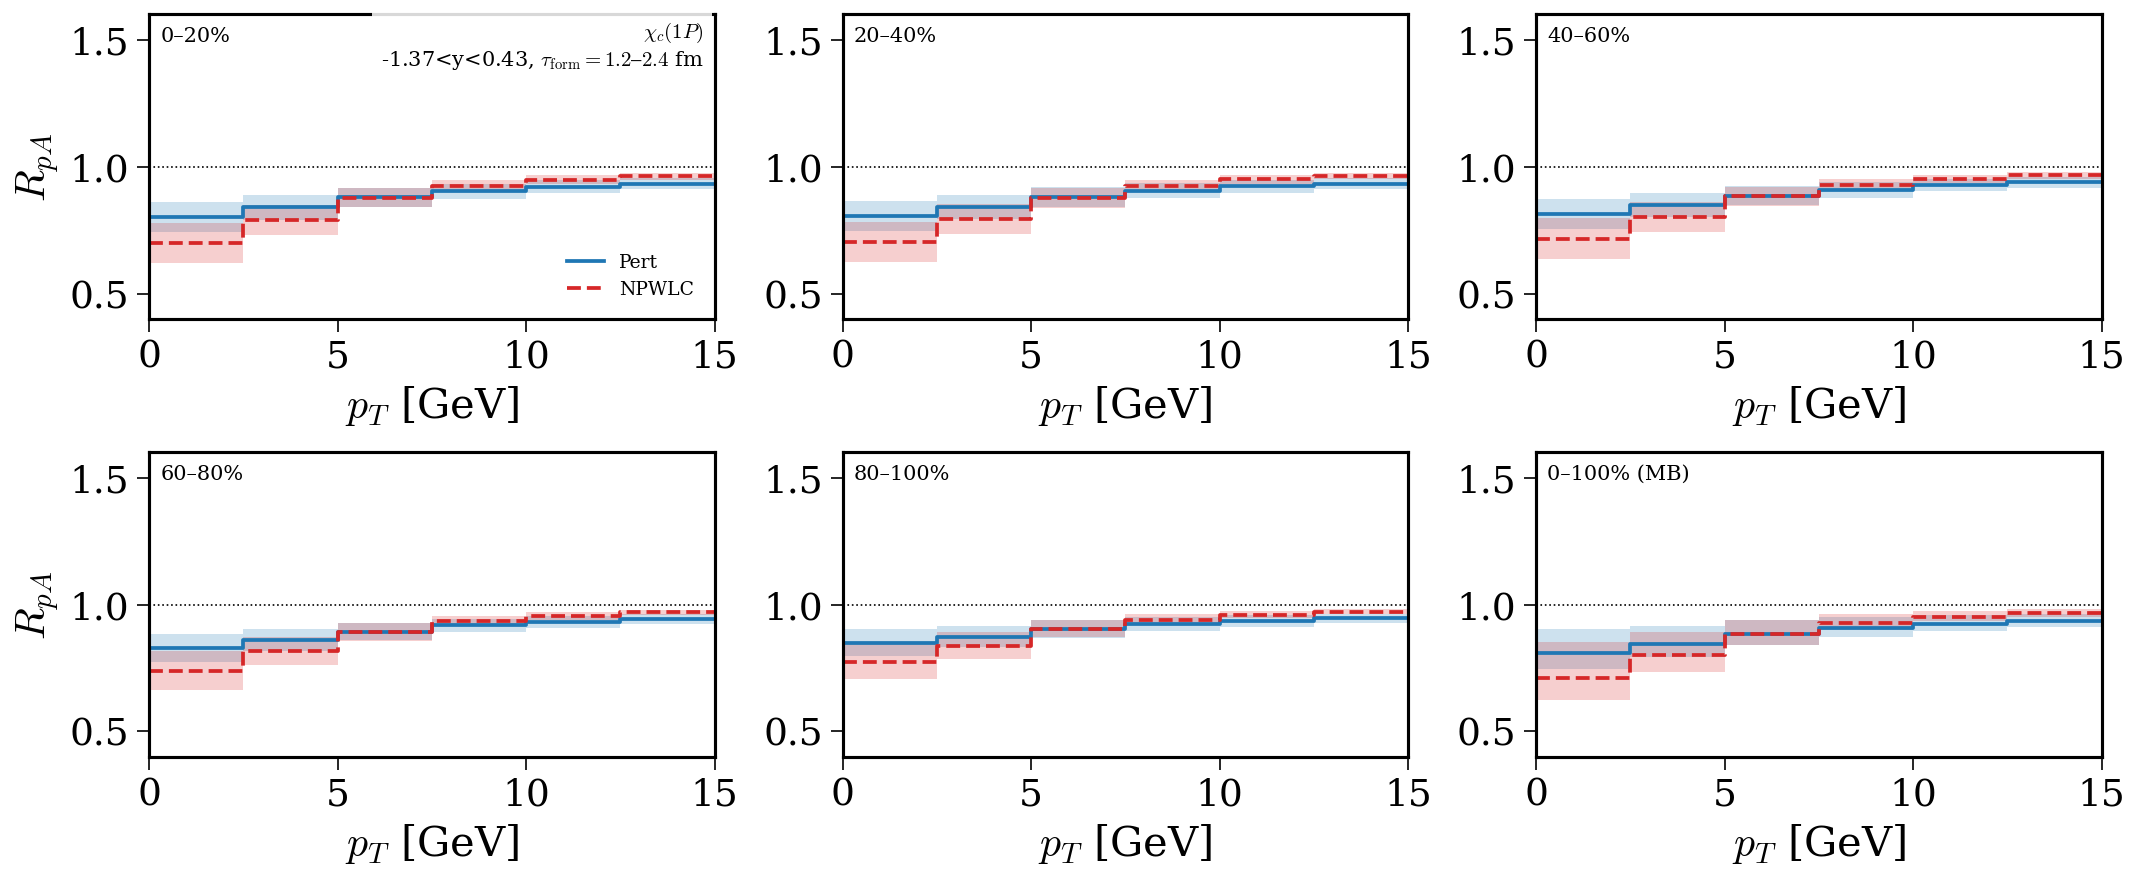

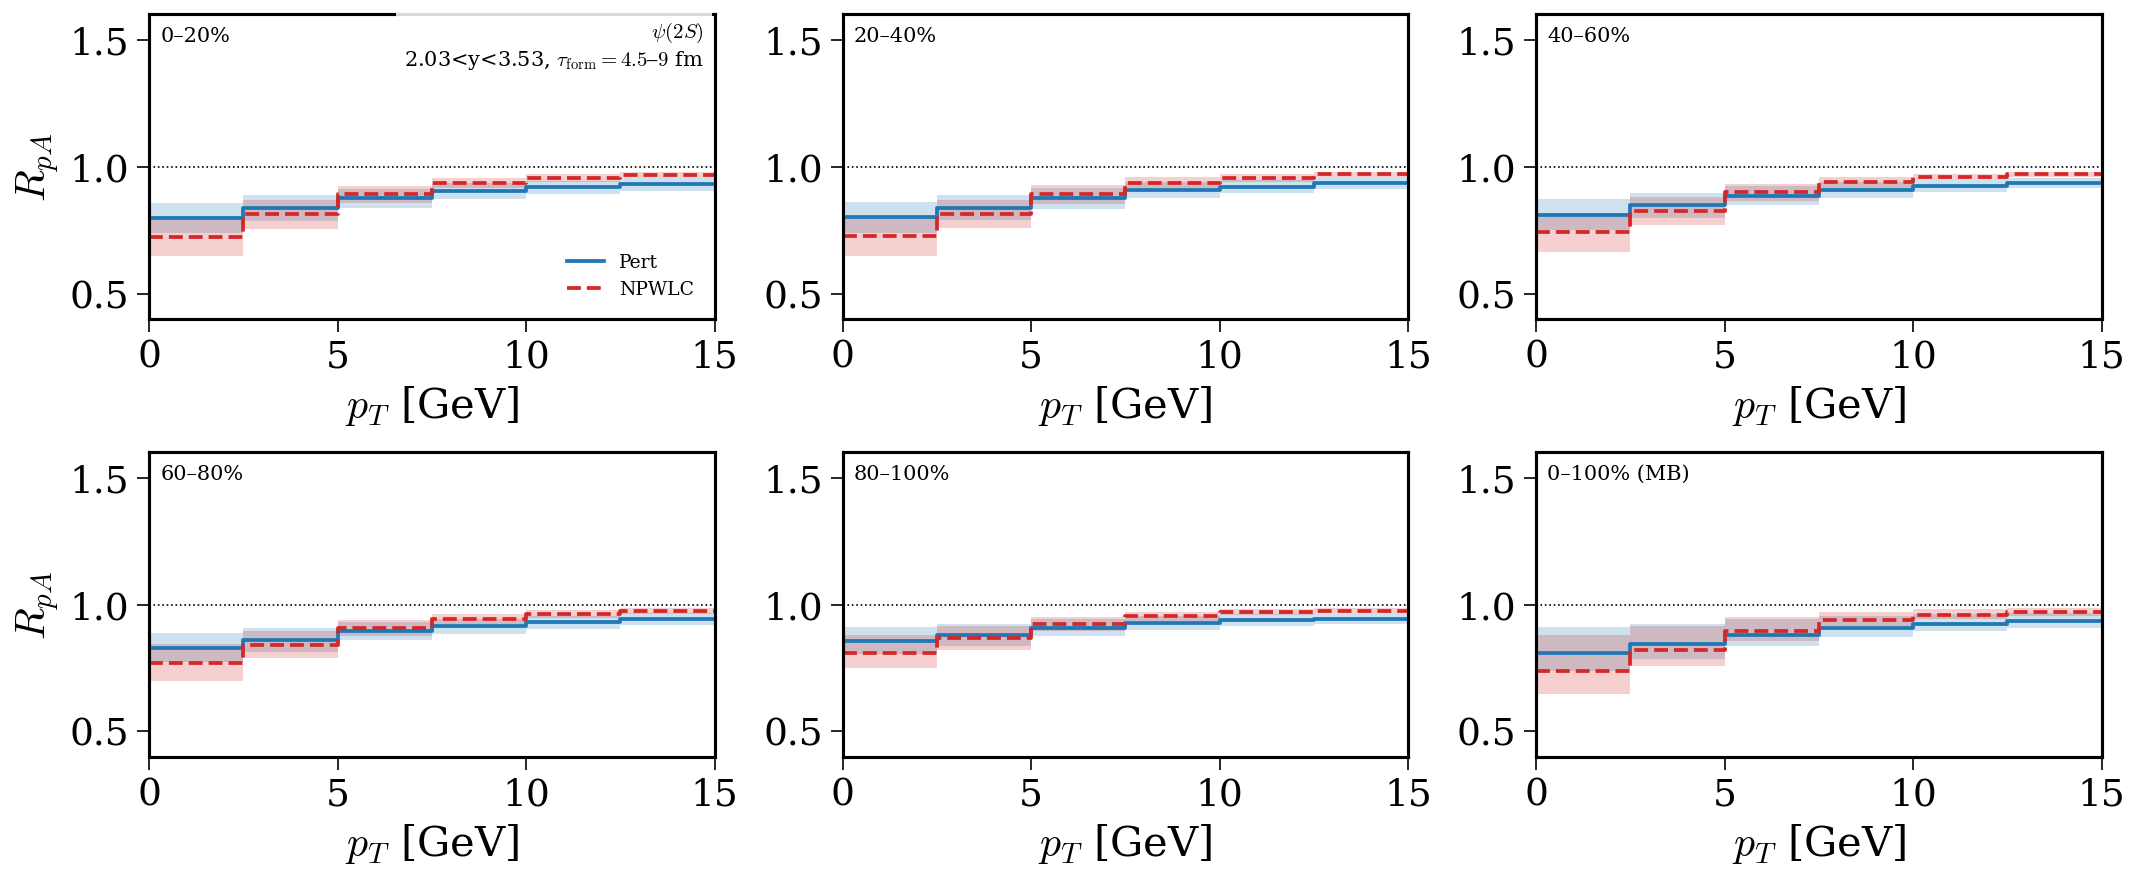

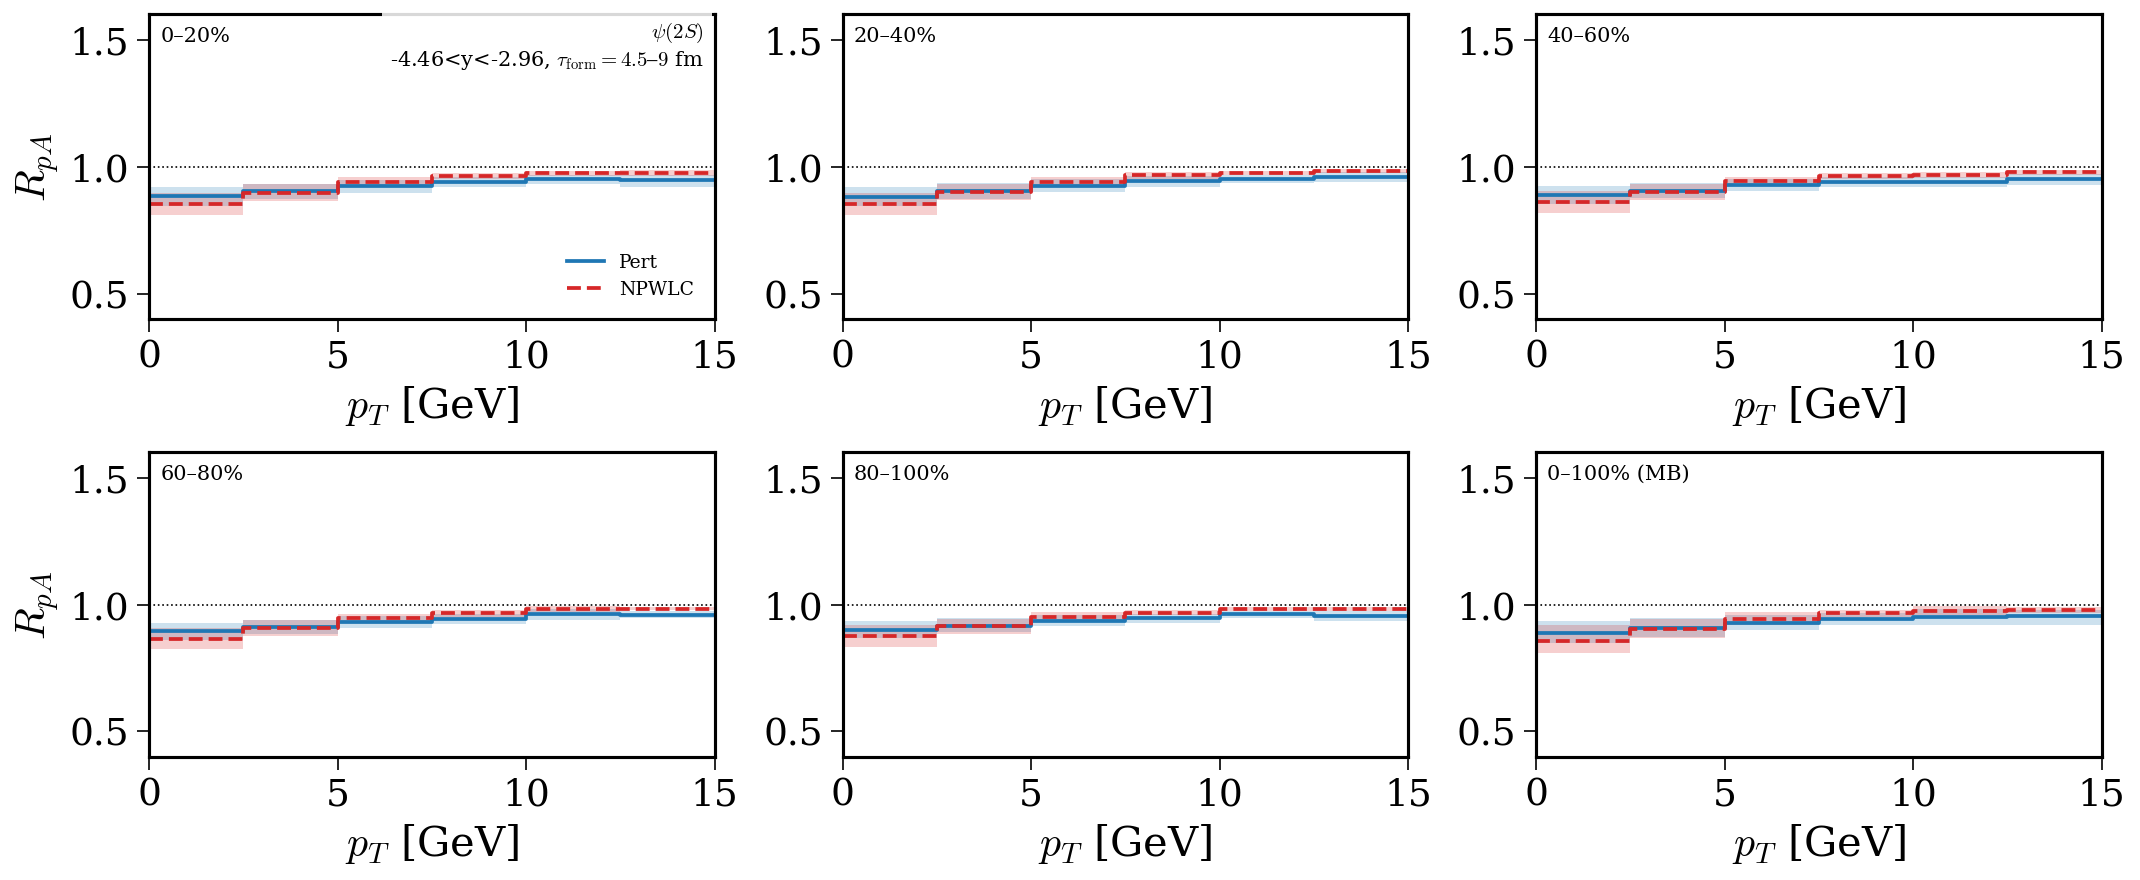

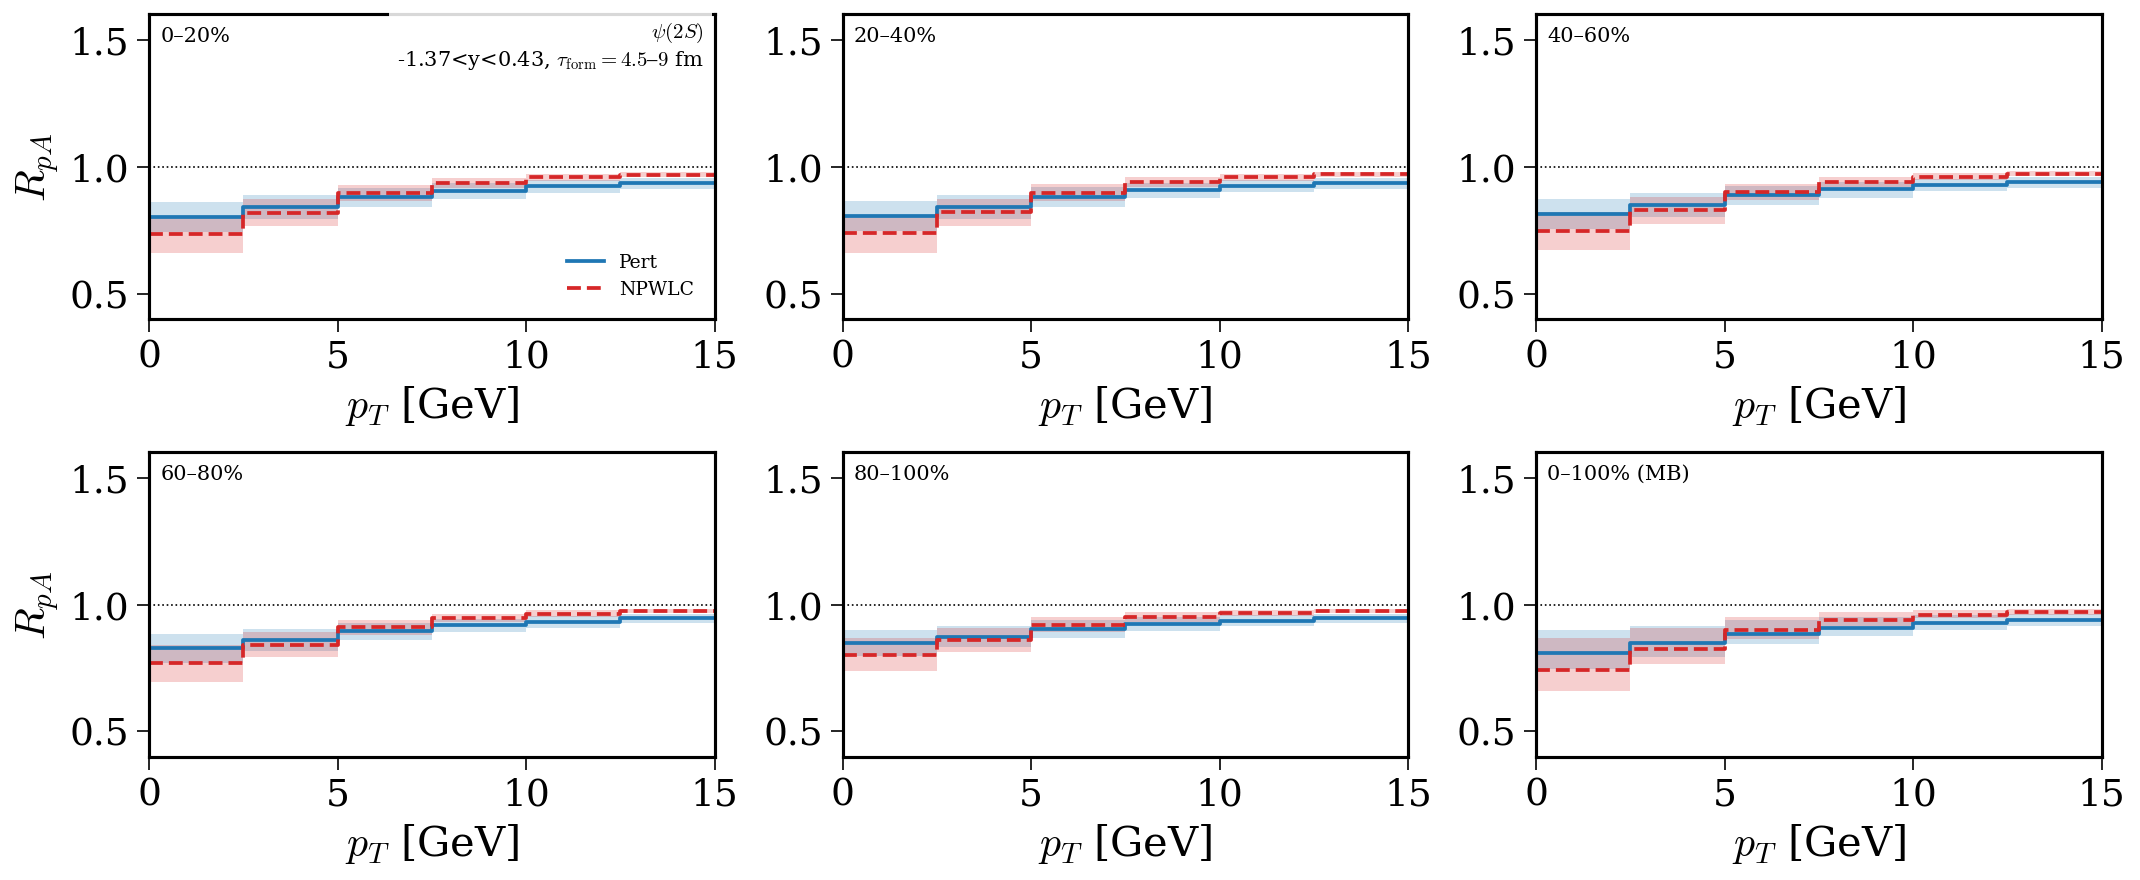

In [29]:
# ------------- R_pA vs pT: one state per figure, per y-window, centrality panels -------------
YLIMS_PT = {
    "forward":  (0.4, 1.6),
    "central":  (0.4, 1.6),
    "backward": (0.4, 1.6),
}

for state in PLOT_STATES:
    for yname, y0, y1 in _iter_ywins(Y_WINS):  # keep same order as CNM windows
        if yname not in prim_pt:
            continue
        models_block = prim_pt[yname]
        if not models_block:
            continue

        cent_tags = _sorted_cent_tags(models_block)
        n_cent = len(cent_tags)
        n_cols = 3
        n_rows = int(np.ceil(n_cent / n_cols))

        fig, axes = plt.subplots(
            n_rows, n_cols,
            figsize=(4.8*n_cols, 3.0*n_rows),
            dpi=DPI, sharex=False, sharey=False
        )
        axes = np.atleast_1d(axes).ravel()

        for ip, cent_tag in enumerate(cent_tags):
            ax = axes[ip]
            for model in MODELS:
                if model not in models_block:
                    continue
                if cent_tag not in models_block[model]:
                    continue
                if state not in models_block[model][cent_tag]:
                    continue

                Rc, Rlo, Rhi, pT_cent = models_block[model][cent_tag][state]
                x_edges, y_c  = step_from_centers(pT_cent, Rc)
                _,       y_lo = step_from_centers(pT_cent, Rlo)
                _,       y_hi = step_from_centers(pT_cent, Rhi)

                col = MODEL_COLORS[model]
                ls  = MODEL_LS[model]
                lab = model if ip == 0 else None

                ax.step(x_edges, y_c, where="post", color=col, ls=ls, lw=1.8, label=lab)
                ax.fill_between(
                    x_edges, y_lo, y_hi,
                    step="post",
                    color=col, alpha=ALPHA_BAND, linewidth=0.0
                )

            ax.axhline(1.0, color="k", ls=":", lw=0.8)
            ax.set_xlim(PT_WINDOW[0], PT_WINDOW[1])
            ax.set_ylim(*YLIMS_PT.get(yname, (0.3, 1.8)))
            ax.set_xlabel(r"$p_T$ [GeV]")
            if ip % n_cols == 0:
                ax.set_ylabel(r"$R_{pA}$")
            ax.grid(False)

            # centrality label inside panel
            ax.text(
                0.02, 0.96, cent_tag,
                transform=ax.transAxes,
                ha="left", va="top",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.75, edgecolor="none")
            )

        # hide unused axes
        for k in range(n_cent, len(axes)):
            axes[k].set_visible(False)

        # legend: models only
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            axes[0].legend(handles, labels, loc="lower right", fontsize=9, frameon=False)

        # note with state + τ_form + numeric y-window (no pT range)
        tau_lo, tau_hi = TAUFORM[state]
        note = (
            f"{STATE_LABELS[state]}\n"
            rf"{y0:.2f}<y<{y1:.2f}, "
            rf"$\tau_{{\rm form}}={tau_lo:.2g}\text{{–}}{tau_hi:.2g}$ fm"
        )
        _corner(axes[0], note, loc="tr")

        fig.tight_layout()

        if SAVE_PDF:
            safe = yname.replace(" ", "_")
            fig.savefig(
                outdir / f"primordial_RpA_vs_pT_{state}_{safe}_{ENERGY.replace('.','p')}TeV.pdf",
                bbox_inches="tight",
            )

        # CSV per state+window (unchanged logic)
        if SAVE_CSV:
            rows = []
            for model in MODELS:
                if model not in models_block:
                    continue
                for cent_tag in models_block[model]:
                    if state not in models_block[model][cent_tag]:
                        continue
                    Rc, Rlo, Rhi, pT_cent = models_block[model][cent_tag][state]
                    for pv, rc, rlo, rhi in zip(pT_cent, Rc, Rlo, Rhi):
                        rows.append({
                            "energy": ENERGY,
                            "y_window": yname,
                            "model": model,
                            "centrality": cent_tag,
                            "state": state,
                            "pT": pv,
                            "R": rc,
                            "R_lo": rlo,
                            "R_hi": rhi,
                        })
            if rows:
                df_out = pd.DataFrame(rows)
                df_out.to_csv(
                    outdir / f"primordial_RpA_vs_pT_{state}_{yname}_{ENERGY.replace('.','p')}TeV.csv",
                    index=False,
                )

## $R_{pA}$ vs Centrality

In [10]:
prim_cent = {}  # prim_cent[yname][model][state] = (cent_mid, Rc, Rlo, Rhi, Rc_MB, Rlo_MB, Rhi_MB)

def primordial_vs_cent_from_vs_y(
    prim_y,
    y_wins=Y_WINS,
    states=STATES,
):
    out = {}
    for yname, y0, y1 in _iter_ywins(y_wins):
        out[yname] = {}
        for model in MODELS:
            if model not in prim_y:
                continue

            cent_tags = [c for c in prim_y[model].keys() if "MB" not in c]
            mb_tag = [c for c in prim_y[model].keys() if "MB" in c]
            mb_tag = mb_tag[0] if mb_tag else None

            # sort non-MB centralities
            def _cent_key(tag):
                lo, hi = tag.split("–")
                return float(lo)
            cent_tags = sorted(cent_tags, key=_cent_key)

            for s in states:
                cent_mid = []
                Rc_all   = []
                Rlo_all  = []
                Rhi_all  = []

                # per-centrality slice
                for ct in cent_tags:
                    if s not in prim_y[model][ct]:
                        continue
                    Rc, Rlo, Rhi, y_cent = prim_y[model][ct][s]
                    mask = (y_cent >= y0) & (y_cent <= y1)
                    if not np.any(mask):
                        continue
                    lo_str, hi_str = ct.split("–")
                    lo = float(lo_str); hi = float(hi_str.strip("%"))
                    cent_mid.append(0.5*(lo+hi))

                    Rc_all.append(float(np.mean(Rc[mask])))
                    Rlo_all.append(float(np.min(Rlo[mask])))
                    Rhi_all.append(float(np.max(Rhi[mask])))

                if not cent_mid:
                    continue

                cent_mid = np.array(cent_mid, float)
                Rc_arr   = np.array(Rc_all,   float)
                Rlo_arr  = np.array(Rlo_all,  float)
                Rhi_arr  = np.array(Rhi_all,  float)

                # MB value (single number), if available
                Rc_MB = Rlo_MB = Rhi_MB = np.nan
                if mb_tag and s in prim_y[model][mb_tag]:
                    Rc_mb, Rlo_mb, Rhi_mb, y_mb = prim_y[model][mb_tag][s]
                    mask_mb = (y_mb >= y0) & (y_mb <= y1)
                    if np.any(mask_mb):
                        Rc_MB  = float(np.mean(Rc_mb[mask_mb]))
                        Rlo_MB = float(np.min(Rlo_mb[mask_mb]))
                        Rhi_MB = float(np.max(Rhi_mb[mask_mb]))

                out[yname].setdefault(model, {})[s] = (
                    cent_mid, Rc_arr, Rlo_arr, Rhi_arr, Rc_MB, Rlo_MB, Rhi_MB
                )

    return out

prim_cent = primordial_vs_cent_from_vs_y(prim_y)


ValueError: x and y must have same first dimension, but have shapes (6,) and (2,)

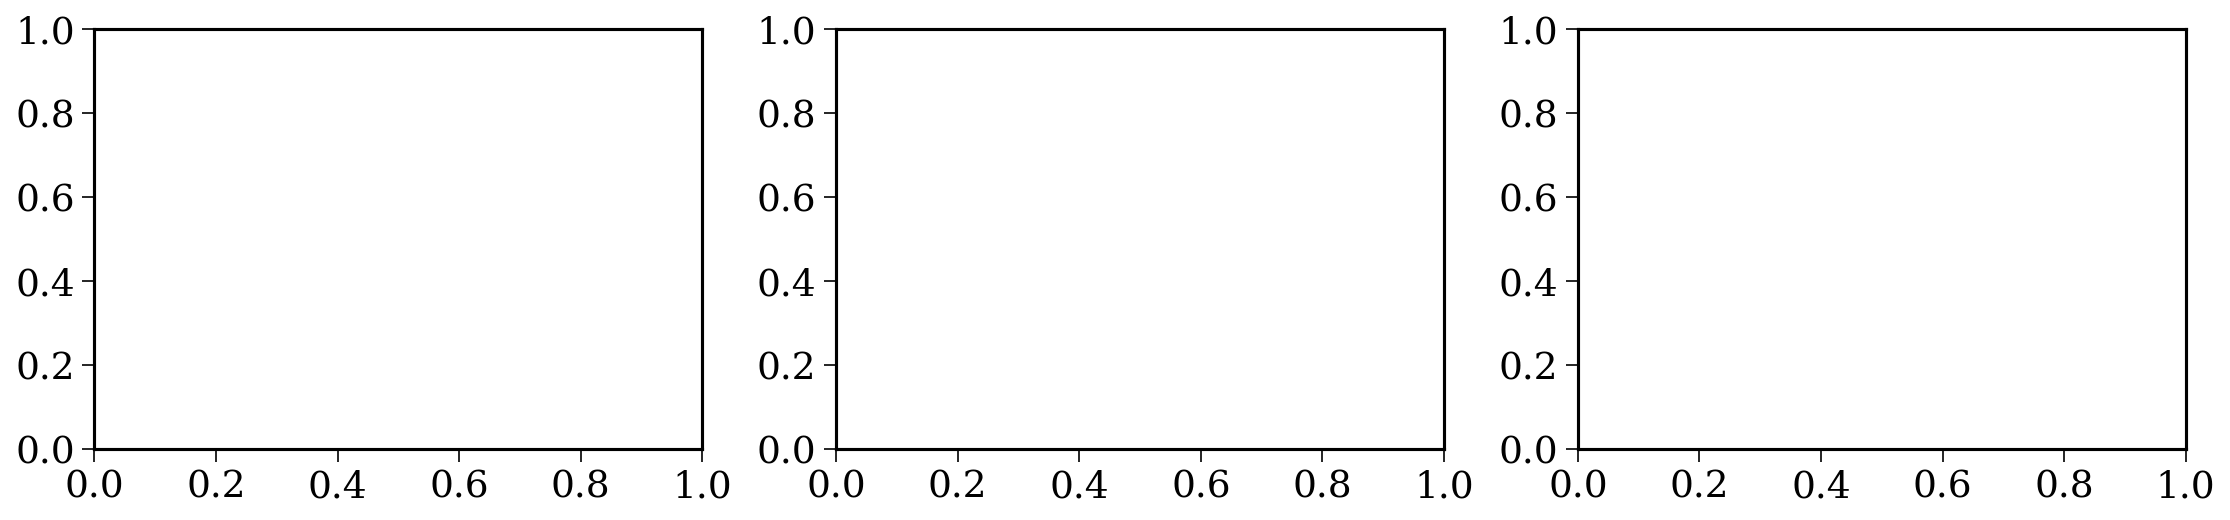

In [33]:
# ------------- R_pA vs centrality: one state per figure, 3 y-windows -------------
for state in PLOT_STATES:
    # three panels: backward / central / forward (or whatever Y_WINS defines)
    ywins_list = list(_iter_ywins(Y_WINS))
    n_pan = len(ywins_list)

    fig, axes = plt.subplots(1, n_pan, figsize=(5.0 * n_pan, 3.6), dpi=DPI, sharey=False)
    axes = np.atleast_1d(axes)

    for iax, (yname, y0, y1) in enumerate(ywins_list):
        ax = axes[iax]
        if yname not in prim_cent:
            ax.set_visible(False)
            continue

        for model in MODELS:
            if model not in prim_cent[yname]:
                continue
            if state not in prim_cent[yname][model]:
                continue

            cent_mid, Rc, Rlo, Rhi, Rc_MB, Rlo_MB, Rhi_MB = prim_cent[yname][model][state]

            # Use explicit centrality bin edges like in CNM notebook
            edges = np.array(
                [CENT_CLASSES[0][0]] + [hi for (_, hi) in CENT_CLASSES],
                float
            )
            # assume Rc etc correspond to CENT_CLASSES in order
            y_c  = np.concatenate([Rc,  Rc[-1:]])
            y_lo = np.concatenate([Rlo, Rlo[-1:]])
            y_hi = np.concatenate([Rhi, Rhi[-1:]])

            col = MODEL_COLORS[model]
            ls  = MODEL_LS[model]
            lab = model if iax == 0 else None

            ax.step(edges, y_c, where="post", color=col, ls=ls, lw=1.8, label=lab)
            ax.fill_between(
                edges, y_lo, y_hi,
                step="post",
                color=col, alpha=ALPHA_BAND, linewidth=0.0
            )

            # MB: dashed horizontal line with same color
            if np.isfinite(Rc_MB):
                ax.hlines(
                    Rc_MB, 0.0, 100.0,
                    colors=col, linestyles=":", linewidth=1.5,
                    label=None
                )

        ax.axhline(1.0, color="k", ls=":", lw=0.8)
        ax.set_xlim(0.0, 100.0)
        ax.set_ylim(0.3, 1.4)
        ax.set_xlabel("Centrality [%]")
        if iax == 0:
            ax.set_ylabel(r"$R_{pA}$")
        ax.grid(False)

        # y-range note + panel label
        label = f"{y0:.2f}<y<{y1:.2f}"
        ax.text(
            0.02, 0.96, label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none")
        )

    # legend: Pert / NPWLC
    handles, labels = axes[0].get_legend_handles_labels()
    if handles:
        axes[0].legend(handles, labels, loc="lower right", frameon=False, fontsize=9)

    # state + τ_form + √s note (once per figure)
    tau_lo, tau_hi = TAUFORM[state]
    note = (
        f"{STATE_LABELS[state]}\n"
        rf"$\tau_{{\rm form}}={tau_lo:.2g}\text{{–}}{tau_hi:.2g}$ fm, "
        rf"$\sqrt{{s_{{NN}}}}={float(ENERGY):.2f}$ TeV"
    )
    _corner(axes[0], note, loc="tr")

    fig.tight_layout()

    if SAVE_PDF:
        fig.savefig(
            outdir / f"primordial_RpA_vs_cent_{state}_{ENERGY.replace('.','p')}TeV.pdf",
            bbox_inches="tight"
        )

    # CSV export is fine as you already wrote it; you can keep your existing block.